In [1]:
'''
    In this file, I try to apply the L2
    L2 regularization, also known as weight decay, is a technique used to prevent overfitting in machine learning models by adding a penalty to the loss function. 
    It works by discouraging large weight values, which helps the model generalize better to unseen data.
'''
# Import everything we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Step 1: Load data
loaded_data = pd.read_csv("./Resources/2024_ionosphere_data.csv", header=None)

# Shuffle the dataset
# shuffled_data = loaded_data.sample(frac=1).reset_index(drop=True)
shuffled_data = loaded_data

# Convert the 'g'/'b' labels to numeric (1 for 'g' and 0 for 'b')
shuffled_data.iloc[:, 34] = shuffled_data.iloc[:, 34].replace({
    "g": 1,
    "b": 0
}).astype(int)  # Ensure conversion to integers

# Split X and Y (Change to numpy type)
X = shuffled_data.iloc[:, 0:34].values  
Y = shuffled_data.iloc[:, 34].astype(int).to_numpy()

# Check the data types
print("Data type of X:", X.dtype)
print("Data type of Y:", Y.dtype) 

# Now split the dataset into training and testing sets
test_size = int(0.2 * len(X))
train_size = len(X) - test_size

X_train = X[:train_size]
Y_train = Y[:train_size].reshape(-1,1)
X_test = X[train_size:]
Y_test = Y[train_size:].reshape(-1,1)

# Verify shapes and data types
print("Training set shape:", X_train.shape, Y_train.shape)
print("Testing set shape:", X_test.shape, Y_test.shape)

print(type(Y_train))
print(type(X_train))
print(X_train.dtype)
print(Y_train.dtype)


Data type of X: float64
Data type of Y: int32
Training set shape: (281, 34) (281, 1)
Testing set shape: (70, 34) (70, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
float64
int32


C:\Users\brado\AppData\Local\Temp\ipykernel_22524\209609328.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shuffled_data.iloc[:, 34] = shuffled_data.iloc[:, 34].replace({


In [6]:
# Step 2: Define necessary functions

def initialize_weights(layer_dims, seed = None):
    weights = {}
    biases = {}

    # Setup seed
    if (seed is not None):
        np.random.seed(seed)

    # Loop through the layers and initialize weights and biases using He Initialization
    for i in range(1, len(layer_dims)):  # Start from layer 1 to layer_dims-1
        # He initialization for weights
        weights[f"W{i}"] = np.random.randn(layer_dims[i-1], layer_dims[i]).astype(np.float64) * np.sqrt(2 / layer_dims[i-1])
        biases[f"b{i}"] = np.zeros((1, layer_dims[i]), dtype=np.float64)
        
    return weights, biases

def binary_cross_entropy_loss(y_true, y_pred, weights, lambda_val):
    epsilon = 1e-12  # Small constant to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip to avoid log(0)

    # Standard binary cross-entropy loss
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # L2 regularization term
    L2_regularization = 0
    for l in range(1, len(weights) + 1):
        L2_regularization += np.sum(np.square(weights[f"W{l}"]))

    # Add the L2 regularization term to the loss
    loss += (lambda_val / (2 * len(y_true))) * L2_regularization

    return loss


def dbinary_crossentropy_loss(p_pred, y_true):
    return (-y_true / p_pred) + (1 - y_true) / (1 - p_pred)


# Sigmoid activation function
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Clip to avoid overflow errors
    return 1 / (1 + np.exp(-x))


# Sigmoid derivative (used in backpropagation)
def sigmoid_derivative(x):
    return x * (1 - x)  # Derivative of sigmoid


# ReLU activation function
def relu(x):
    return np.maximum(0, x)


# ReLU derivative (for backpropagation)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def forward_propagation(X, weights, biases):
    Xi = X  # Input layer
    Z = {}
    A = {}
    L = len(
        weights
    )  # Number of layers / Just 3 weights inside --> So we need plus one for layers

    for index in range(1, L + 1):  # Loop over layers from 1 to L
        W = weights[f"W{index}"]
        b = biases[f"b{index}"]
        Zi = np.dot(Xi, W) + b
        Z[f"Z{index}"] = Zi

        # Apply Sigmoid activation for the last layer, ReLU for hidden layers
        if index == L:
            Ai = sigmoid(Zi)
        else:
            Ai = relu(Zi)

        A[f"A{index}"] = Ai
        Xi = Ai  # Output of current layer becomes input to the next layer

    return Z, A


def backward_propagation(
    X, Y, Z, A, weights, output_activation="sigmoid", hidden_activation="relu"
):
    m = X.shape[0]  # Number of examples
    gradients = {}
    L = len(weights)  # Number of layers with weights
    # Step 1: Initialize the derivative for the output layer
    A_last = A[f"A{L}"]  # The predicted output from the last layer

    if output_activation == "sigmoid":
        dA_last = A_last - Y  # Error at the output layer for sigmoid
    else:
        raise NotImplementedError(
            "Currently supports sigmoid for the output layer only."
        )

    dA_next = dA_last

    # Step 2: Backpropagation through layers (from L to 1)
    for l in reversed(range(1, L + 1)):
        if l == L:  # For the output layer, use dA_last directly
            dZ = dA_last
        else:
            # For hidden layers, backpropagate the error
            if hidden_activation == "relu":
                # Ensure proper reshaping of dA_next and weights for matrix multiplication
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * relu_derivative(
                    Z[f"Z{l}"]
                )  # Apply derivative of activation
            elif hidden_activation == "sigmoid":
                dA_next = np.dot(dA_next, weights[f"W{l+1}"].T)
                dZ = dA_next * sigmoid_derivative(
                    A[f"A{l}"]
                )  # Apply derivative of sigmoid
            else:
                raise NotImplementedError(
                    f"Unsupported activation function: {hidden_activation}"
                )

        # Compute gradients for weights and biases
        A_prev = (
            A[f"A{l-1}"] if l > 1 else X
        )  # A_prev is the activation from the previous layer or input X
        gradients[f"dW{l}"] = np.dot(A_prev.T, dZ) / m  # Gradient of W
        gradients[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m  # Gradient of b

        # Store dA_next for the next iteration
        dA_next = dZ

    return gradients


def update_parameters(weights, biases, gradients, learning_rate, lambda_val):
    L = len(weights)  # Number of layers in the network

    # Update each layer's weights and biases
    for l in range(1, L + 1):
        # Update weights with L2 regularization (W = W - learning_rate * (dW + lambda * W))
        weights[f"W{l}"] -= learning_rate * (
            gradients[f"dW{l}"] + lambda_val * weights[f"W{l}"]
        )

        # Update biases (no regularization for biases)
        biases[f"b{l}"] -= learning_rate * gradients[f"db{l}"]

    return weights, biases


def save_parameters(weights, biases, index):
    file_path = "./Parameters"
    np.save(f"{file_path}/weights_{index}.npy", weights)
    np.save(f"{file_path}/biases_{index}.npy", biases)

In [13]:
# Example usage of initialize function
'''
    You can run multiple times to see the values of weights and biases do not change.
    We can use those values for a lot of test after we change our parameters.
'''
layer_dims = [64, 128, 64, 32, 1]  # Example for a network with 3 hidden layers
weights, biases = initialize_weights(layer_dims, seed=42) # Fixed the values of weights and biases

# Output the initialized weights and biases (you can print to check them)
print("Weights:", weights)
print("Biases:", biases)

Weights: {'W1': array([[ 0.08780749, -0.02444191,  0.11449624, ...,  0.38722151,
        -0.17510374, -0.10010824],
       [ 0.01761604, -0.08900276, -0.27412116, ...,  0.1825158 ,
        -0.2685892 , -0.0856013 ],
       [ 0.22396037, -0.12509947,  0.07845693, ..., -0.10595865,
        -0.37545527, -0.09294124],
       ...,
       [ 0.28978235, -0.33990124,  0.10201291, ...,  0.24044603,
        -0.03353339,  0.15018675],
       [-0.39219147,  0.42758354,  0.26436217, ...,  0.02662301,
        -0.26570366,  0.17601545],
       [-0.15581694,  0.01596467,  0.20584086, ...,  0.16733275,
         0.10678225, -0.07248364]]), 'W2': array([[-0.00885461,  0.01139061,  0.01346243, ..., -0.12815239,
         0.01436772,  0.17841608],
       [ 0.14021114,  0.02863685, -0.04039596, ...,  0.10507584,
        -0.1031615 , -0.06161478],
       [-0.25127708, -0.16549389,  0.22595385, ...,  0.03829344,
         0.01157845,  0.15535782],
       ...,
       [-0.1697279 , -0.04621459,  0.22857816, ..., 

In [14]:
def train(
        X, 
        Y, 
        layer_dims, 
        epoches, 
        learning_rate, 
        train_losses, 
        X_test, 
        Y_test, 
        test_losses, 
        lambda_val,
        seed    
    ):
    weights = {}
    biases = {}
    # Initialize weights and biases
    if (seed is not None):
        weights, biases = initialize_weights(layer_dims, seed)
    else:
        weights, biases = initialize_weights(layer_dims)
    # Training loop
    for i in range(epoches):
        # Forward propagation
        Z, A = forward_propagation(X, weights, biases)
        # Calculate training loss
        train_loss = binary_cross_entropy_loss(Y, A[f"A{len(layer_dims) - 1}"], weights, lambda_val)
        train_losses.append(train_loss)
        
        # Print epoch tracking every 500 epochs
        if i % 500 == 0:
            print(f"Epoch {i+1}/{epoches}, Loss: {train_loss}")
        
        # Backward propagation
        gradients = backward_propagation(X, Y, Z, A, weights, "sigmoid", "relu")
        weights, biases = update_parameters(weights, biases, gradients, learning_rate, lambda_val)
        
        # Test set forward propagation
        _, A_test = forward_propagation(X_test, weights, biases)
        
        # Calculate test loss
        test_loss = binary_cross_entropy_loss(Y_test, A_test[f"A{len(layer_dims) - 1}"], weights, lambda_val)
        test_losses.append(test_loss)

    return weights, biases


In [21]:
# Step 4: Let's train it!
lambda_val = 0.005
index_run = 1
layer_dims = [34, 16, 2, 1]  # Input: 34 features, 16 hidden units, 2 latent neurons, 1 output neuron
epoches = 10000      
train_losses = []
test_losses = []
learning_rate = 0.01

weights, biases = train(
    X_train, 
    Y_train, 
    layer_dims, 
    epoches, 
    learning_rate, 
    train_losses, 
    X_test, 
    Y_test, 
    test_losses, 
    lambda_val,
    seed=42 # Do not change the initialization
)
save_parameters(weights, biases, index_run)

Epoch 1/10000, Loss: 0.6974097766314673
Epoch 501/10000, Loss: 0.6254624564672057
Epoch 1001/10000, Loss: 0.5435723983419869
Epoch 1501/10000, Loss: 0.46212034558334364
Epoch 2001/10000, Loss: 0.34346312155989717
Epoch 2501/10000, Loss: 0.2605333803326915
Epoch 3001/10000, Loss: 0.21086107889355166
Epoch 3501/10000, Loss: 0.17840404505825372
Epoch 4001/10000, Loss: 0.1554260388419051
Epoch 4501/10000, Loss: 0.13886339731634526
Epoch 5001/10000, Loss: 0.1258936854594567
Epoch 5501/10000, Loss: 0.11515551102522144
Epoch 6001/10000, Loss: 0.10629169860872632
Epoch 6501/10000, Loss: 0.09884081968018787
Epoch 7001/10000, Loss: 0.09252457804502116
Epoch 7501/10000, Loss: 0.08706471721353873
Epoch 8001/10000, Loss: 0.0821907531565375
Epoch 8501/10000, Loss: 0.07789457102293983
Epoch 9001/10000, Loss: 0.0739922773760289
Epoch 9501/10000, Loss: 0.07054529574139547


Good or Bad - Binary Cross Entropy Loss on Train Set: 0.39365401752993395
Good or Bad - Binary Cross Entropy Loss on Test Set: 0.39605213160033464


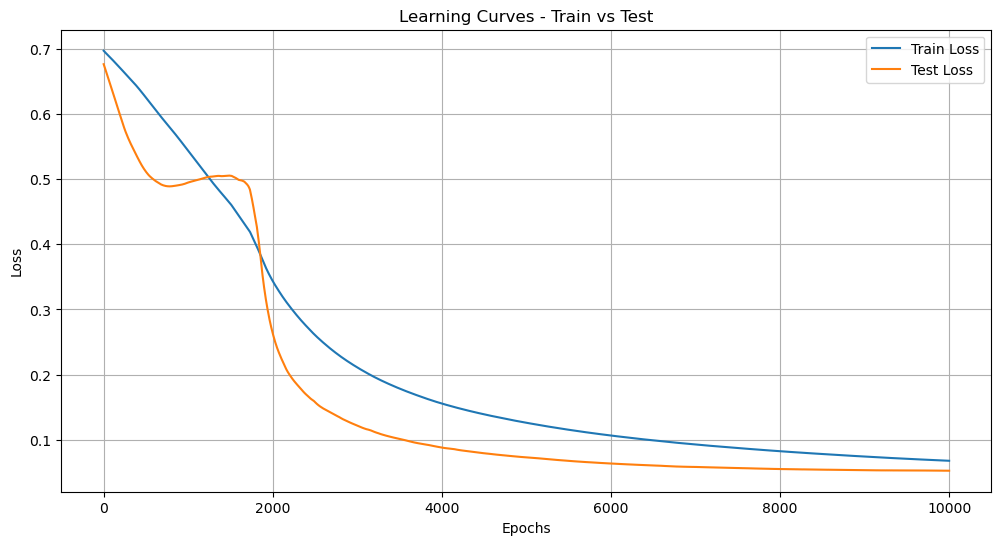

In [22]:
# Step 5: Predict
_, A_test = forward_propagation(X_test, weights, biases)
_, A_train = forward_propagation(X_train, weights, biases)

Y_pred_test = A_test[f"A{len(layer_dims)-1}"]
Y_pred_train = A_train[f"A{len(layer_dims)-1}"]

# Evaluate the performance for TRAIN using Calculate Binary Cross-Entropy Loss on the Training Set
bce_loss_train = binary_cross_entropy_loss(Y_train, Y_pred_train, weights, lambda_val)  # Y_pred_train are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Train Set: {bce_loss_train}")

# Calculate Binary Cross-Entropy Loss on the Test Set
bce_loss_test = binary_cross_entropy_loss(Y_test, Y_pred_test, weights, lambda_val)  # Y_pred_test are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Test Set: {bce_loss_test}")

# Visualize the learning curve (TRAIN DATA and TEST DATA combined)
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Learning Curves - Train vs Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()  # Show legend to differentiate between train and test curves
plt.grid(True)
plt.show()
